In [1]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

# 데이터셋 경로
data_dir = "input/dataset_split"
phases = ['train', 'val', 'test']
class_names = ["Bacteria", "COVID-19", "Normal", "Viral"]

cuda:0


In [3]:
# 이미지 리사이즈 및 패딩 함수
def resize_and_pad(image, size=(1024, 1024)):
    old_size = image.size  # old_size is in (width, height) format
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.LANCZOS)
    new_image = Image.new("RGB", size)  # "RGB" 모드로 새 이미지 생성
    new_image.paste(image, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    return new_image

# 마스크 리사이즈 및 패딩 함수
def resize_and_pad_mask(mask, size=(1024, 1024)):
    old_size = mask.size  # old_size is in (width, height) format
    ratio = float(size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    mask = mask.resize(new_size, Image.NEAREST)  # 마스크는 NEAREST로 리사이즈
    new_mask = Image.new("L", size)
    new_mask.paste(mask, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    return new_mask

# 데이터 변환 정의
def data_transforms(phase):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: resize_and_pad(img)),  # 리사이즈 및 패딩 적용
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    return transform

# 마스크 불러오기 함수
def load_mask(mask_path):
    mask = Image.open(mask_path).convert("L")
    mask = resize_and_pad_mask(mask)  # 마스크에도 리사이즈 및 패딩 적용
    mask = transforms.functional.to_tensor(mask)
    mask = (mask > 0).float()
    return mask

# N-CLAHE 적용 함수
def apply_n_clahe(image, mask):
    image = np.array(image.permute(1, 2, 0).cpu().numpy() * 255, dtype=np.uint8)
    mask = mask.cpu().numpy().astype(np.uint8).squeeze()

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for i in range(3):  # Assuming the image is in RGB format
        channel = image[:, :, i]
        clahe_channel = clahe.apply(channel)
        image[:, :, i] = np.where(mask == 1, clahe_channel, channel)

    return transforms.ToTensor()(image)


In [4]:
# 사용자 정의 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, apply_clahe=False):
        self.img_dir = img_dir
        self.transform = transform
        self.apply_clahe = apply_clahe
        self.img_labels = []
        for class_name in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for img_name in os.listdir(os.path.join(class_path, "images")):
                img_path = os.path.join(class_path, "images", img_name)
                mask_name = os.path.splitext(img_name)[0] + ".png"  # 마스크 파일 확장자를 .png로 설정
                mask_path = os.path.join(class_path, "lung masks", mask_name)
                self.img_labels.append((img_path, mask_path, class_name))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, mask_path, class_name = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        mask = load_mask(mask_path)

        if self.transform:
            image = self.transform(image)

        if self.apply_clahe:
            image = apply_n_clahe(image, mask)

        label = class_names.index(class_name)  # Multi-class classification
        return image, mask, label

In [5]:
# 데이터셋 및 데이터로더 생성
batch_size = 8  # batch size를 늘림
pin_memory = True  # pin_memory 설정

image_datasets = {x: CustomImageDataset(os.path.join(data_dir, x), transform=data_transforms(x), apply_clahe=True) for x in phases}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, pin_memory=pin_memory) for x in phases}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}

In [6]:
# 맞춤 손실 함수 정의
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets, masks):
        # Cross-entropy loss를 계산하고 마스크를 적용합니다
        loss = nn.functional.cross_entropy(inputs, targets, reduction='none')

        # masks를 outputs의 크기에 맞게 확장합니다
        masks = masks.squeeze(1)  # (batch_size, height, width)
        masks = masks.view(masks.size(0), -1).mean(dim=1)  # (batch_size,)
        loss = loss * masks

        return loss.mean()

# 맞춤 손실 함수 사용 예시
criterion = MaskedCrossEntropyLoss()

In [7]:
# EarlyStopping 콜백 클래스 정의
class EarlyStopping:
    def __init__(self, patience=15, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

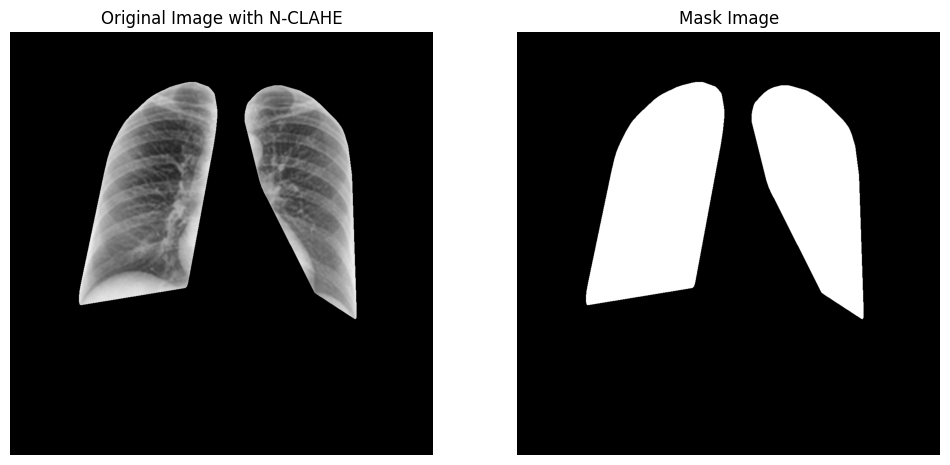

In [8]:
# 샘플 이미지 로드 및 시각화
inputs, masks, labels = next(iter(dataloaders['train']))
input_image = inputs[0]
mask = masks[0]
label = labels[0]

# 원본 이미지와 마스크 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title("Original Image with N-CLAHE")
axes[0].axis("off")

axes[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title("Mask Image")
axes[1].axis("off")

plt.show()

In [9]:
# 학습 시 마스크 적용 및 조기 종료 구현
def train_model_with_mask_and_early_stopping(model, criterion, optimizer, scheduler, early_stopping, num_epochs=60):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs}")
        print("="*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, masks, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"Model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")

            if phase == 'val':
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    break

        scheduler.step(epoch_loss)
        print(f"Learning rate: {scheduler.get_last_lr()}")  # 학습률 출력

        if early_stopping.early_stop:
            break

    print(f'Best val Loss: {best_val_loss:.4f}')

    model.load_state_dict(best_model_wts)
    best_model_save_path = os.path.join('models', 'best_new_pneumonia_model.pth')
    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
    torch.save(model.state_dict(), best_model_save_path)
    print(f'Best model saved to {best_model_save_path}')

    return model

In [10]:
from torchvision.models import ResNet50_Weights

# Load the Pretrained Model
weights = ResNet50_Weights.IMAGENET1K_V1  # 가장 최신 가중치 사용
original_resnet = models.resnet50(weights=weights)
num_features = original_resnet.fc.in_features
original_resnet.fc = nn.Linear(num_features, len(class_names))  # 4개의 클래스로 수정

# 마지막 레이어만 학습 가능하게 설정
for name, param in original_resnet.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 모델을 GPU로 전송
original_resnet = original_resnet.to(device)

# 손실 함수, 옵티마이저, 스케줄러 설정
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, original_resnet.parameters()), lr=0.001, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early_stopping = EarlyStopping(patience=8, verbose=True)

In [11]:
# Train Phase
model_pre = train_model_with_mask_and_early_stopping(original_resnet, criterion, optimizer, scheduler, early_stopping, num_epochs=100)

Epoch: 1/100
train Loss: 0.2278 Acc: 0.5249
val Loss: 0.1536 Acc: 0.6111
Model saved at epoch 1 with val loss: 0.1536
Learning rate: [0.001]
Epoch: 2/100
train Loss: 0.1892 Acc: 0.6189
val Loss: 0.1330 Acc: 0.7667
Model saved at epoch 2 with val loss: 0.1330
Learning rate: [0.001]
Epoch: 3/100
train Loss: 0.1713 Acc: 0.6514
val Loss: 0.1198 Acc: 0.7333
Model saved at epoch 3 with val loss: 0.1198
Learning rate: [0.001]
Epoch: 4/100
train Loss: 0.1649 Acc: 0.6626
val Loss: 0.1197 Acc: 0.7222
Model saved at epoch 4 with val loss: 0.1197
Learning rate: [0.001]
Epoch: 5/100
train Loss: 0.1590 Acc: 0.6782
val Loss: 0.1199 Acc: 0.7222
EarlyStopping counter: 1 out of 8
Learning rate: [0.001]
Epoch: 6/100
train Loss: 0.1546 Acc: 0.6882
val Loss: 0.1155 Acc: 0.7667
Model saved at epoch 6 with val loss: 0.1155
Learning rate: [0.001]
Epoch: 7/100
train Loss: 0.1563 Acc: 0.6831
val Loss: 0.1152 Acc: 0.7556
Model saved at epoch 7 with val loss: 0.1152
Learning rate: [0.001]
Epoch: 8/100
train Loss: